In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 14
}) 

In [3]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

def plot_cv_theta_two(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    _, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)

def plot_qml_vs_smm_estimates(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

    for i in range(3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i], label="y=x", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i]);
    fig.suptitle(title)
    plt.tight_layout()


def plot_qml_vs_smm_cv(df, title,  x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=(7, 7))

    qml_col = "cv_qml"
    smm_col = "cv_smm"
    min_value = min(df[qml_col].min(), df[smm_col].min())
    max_vallue = max(df[qml_col].max(), df[smm_col].max())
    y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
    sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax, label="y=x", color="red", linestyle="--")
    sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax);
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    

In [15]:
def get_winner(theta_2, cv, size):
    is_short = size < 1000
    is_long = 1 - is_short

    is_cv_big = cv > 5.5
    is_cv_med = (1 - is_cv_big) * (cv > 1)
    is_cv_small = 1 - is_cv_big - is_cv_med

    is_theta_small = theta_2 < 0.9
    is_theta_med = (1 - is_theta_small) * (theta_2 < 0.95)
    is_theta_big = 1 - is_theta_small - is_theta_med

    wins_qml = np.zeros_like(size)
    wins_qml += is_long * is_cv_big
    wins_qml += is_long * is_theta_big * is_cv_med
    wins_qml += (size >= 2000) * is_theta_big * is_cv_small
    wins_qml += is_short * (size > 500) * is_theta_small * is_cv_big
    wins_qml = wins_qml > 0

    wins_smm = np.zeros_like(size)
    wins_smm += (size < 2000) * is_cv_small
    wins_smm += (size > 2000) * (size < 4000) * is_cv_small * is_theta_med
    wins_smm += is_cv_med * (1 - is_theta_big)
    wins_smm += is_short * is_theta_big * is_cv_med
    wins_smm = wins_smm > 0

    is_draw = 1 - wins_qml - wins_smm > 0

    smm_literal = pd.Series(["SMM" if flag else "" for flag in wins_smm])
    qml_literal = pd.Series(["QML" if flag else "" for flag in wins_qml])
    draw_literal = pd.Series(["?" if flag else "" for flag in is_draw])
    return smm_literal + qml_literal + draw_literal


def determine_winner(winner_qml, winner_smm):
    is_draw_qml = winner_qml == "?"
    is_draw_smm = winner_smm == "?"

    is_winner =  (winner_smm == winner_qml) * (1 - is_draw_qml) * (1 - is_draw_smm)
    return np.where(is_winner, winner_qml, pd.Series(["?" for _ in range(len(winner_qml))]))



In [16]:
qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")
dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for df in dfs:
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

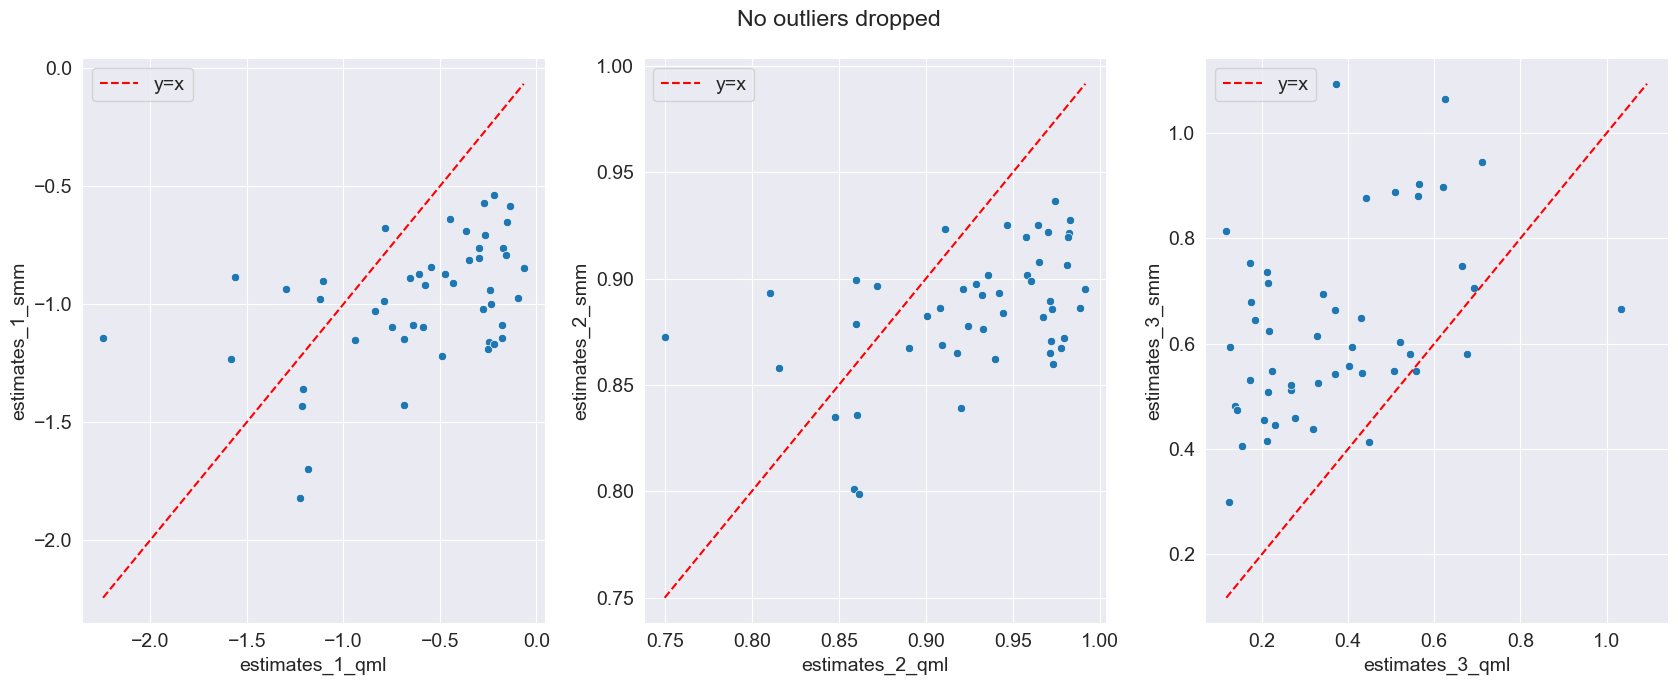

In [17]:
plot_qml_vs_smm_estimates(with_outliers, "No outliers dropped")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

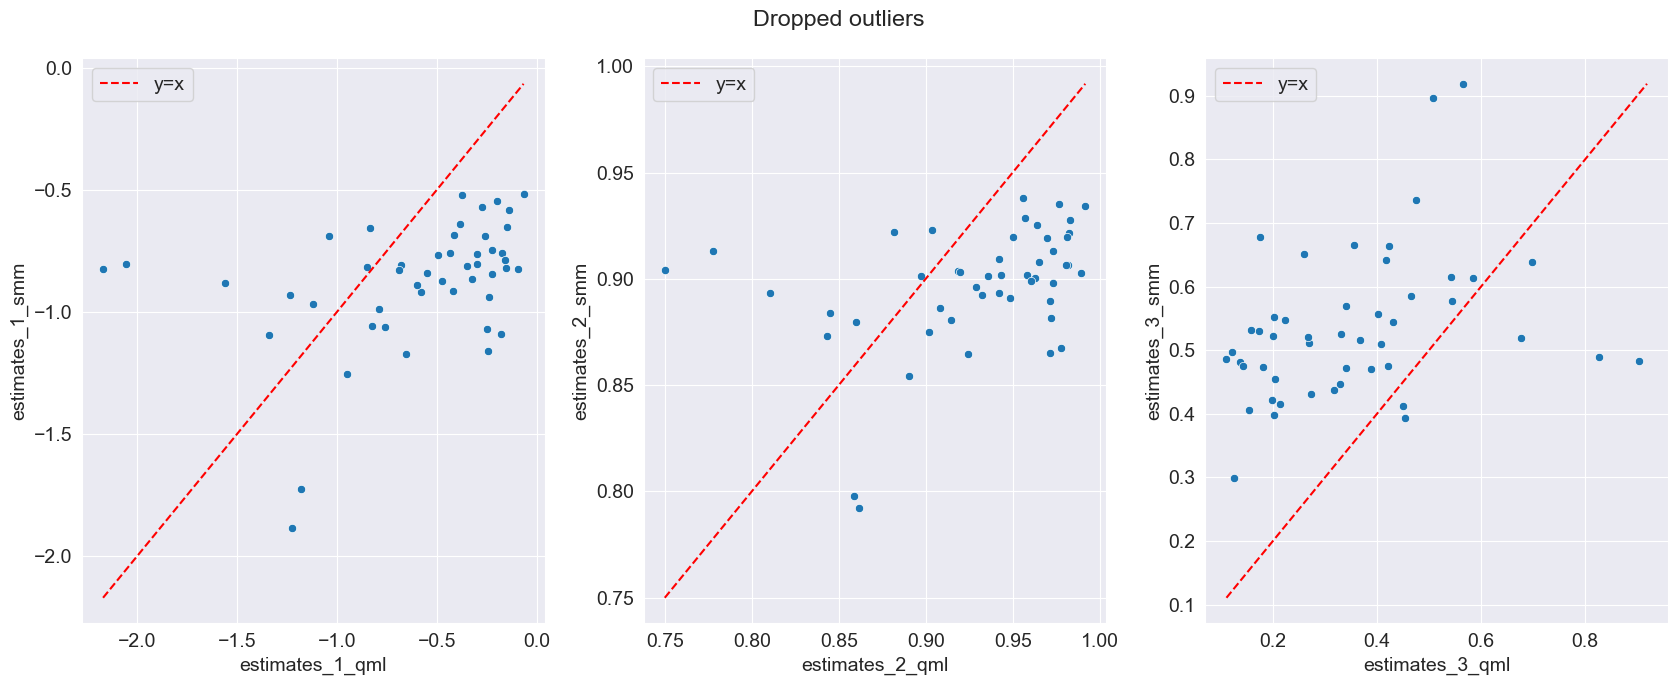

In [18]:
plot_qml_vs_smm_estimates(without_outliers, "Dropped outliers")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


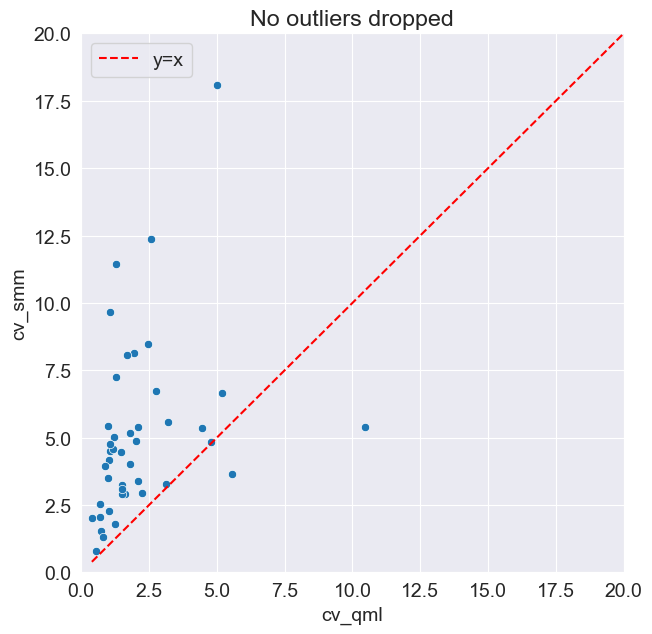

In [19]:
plot_qml_vs_smm_cv(with_outliers, "No outliers dropped", x_bounds=(0, 20), y_bounds=(0, 20))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


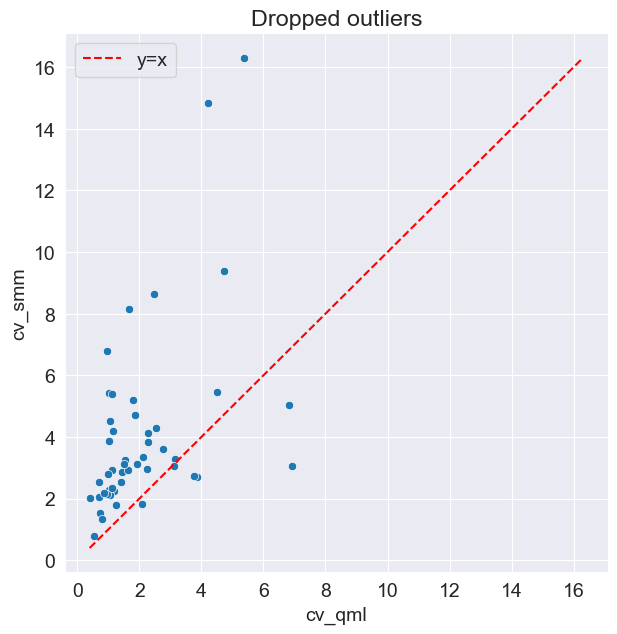

In [20]:
plot_qml_vs_smm_cv(without_outliers, "Dropped outliers")

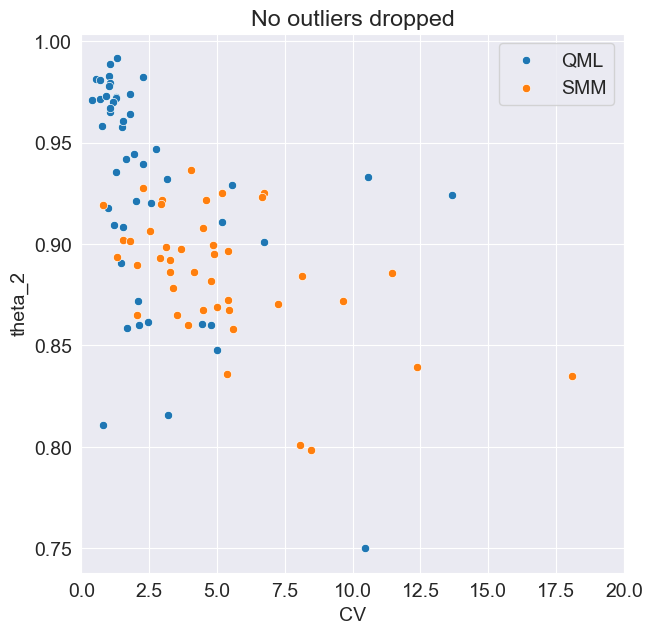

In [21]:
plot_cv_theta_two(qml_with_outliers, smm_with_outliers, "No outliers dropped", x_bounds=(0, 20))

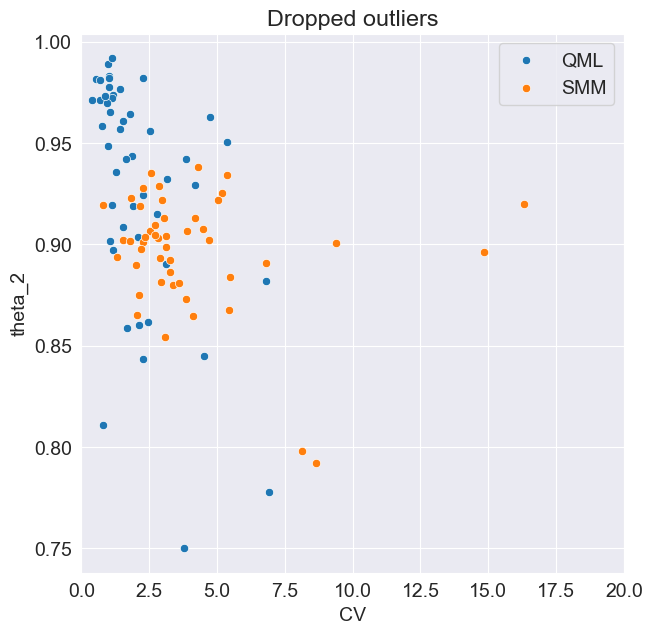

In [22]:
plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "Dropped outliers", x_bounds=(0, 20))

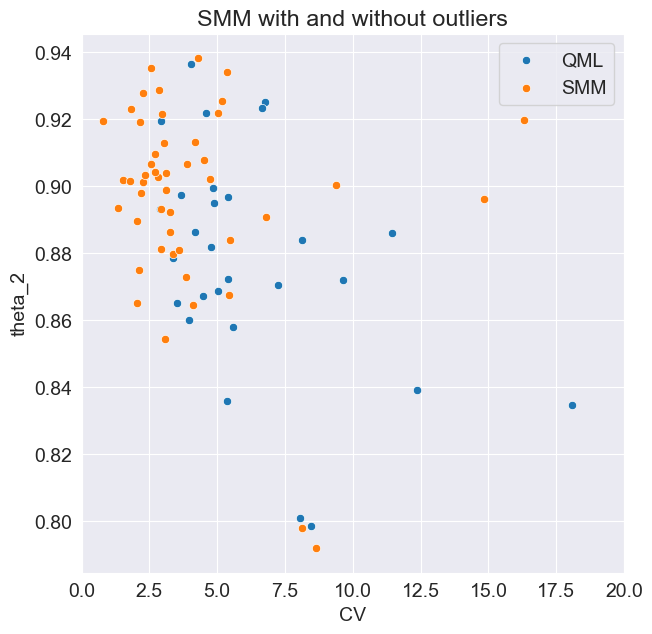

In [23]:
plot_cv_theta_two(smm_with_outliers, smm_without_outliers, "SMM with and without outliers", x_bounds=(0, 20))

In [24]:
smm_with_outliers['name'] = 'smm_with_outliers'
smm_without_outliers['name'] = 'smm_without_outliers'
qml_without_outliers['name'] = 'qml_without_outliers'
qml_with_outliers['name'] = 'qml_with_outliers'


data_length = pd.read_csv('data/merged_data.csv')
data_length =  data_length.groupby(by='ticker').count()['date']

for df in dfs:
    df.set_index('ticker', inplace = True)
    df['size'] = data_length


for df in dfs:
    df["winner"] = get_winner(df["estimates_2"], df["cv"], df["size"]).to_list()


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))


In [25]:
pd.Series(determine_winner(with_outliers.winner_qml, with_outliers.winner_smm)).value_counts(normalize=True)

?      0.625000
SMM    0.291667
QML    0.083333
Name: proportion, dtype: float64

In [26]:
pd.Series(determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)).value_counts(normalize=True)


?      0.5625
SMM    0.4375
Name: proportion, dtype: float64

In [27]:
without_outliers[['estimates_2_qml', 'estimates_2_smm']].max(axis = 1).describe()



count    48.000000
mean      0.939889
std       0.036668
min       0.858842
25%       0.914281
50%       0.945869
75%       0.971590
max       0.991758
dtype: float64

In [28]:
# import plotly_express as px
# fig = px.scatter_3d(full_df, x="estimates_1", y="estimates_2", z="estimates_3", 
#               color="name")
# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=1000
# )
# fig.show()



